In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import waterhealer as wh
import json
import logging

logging.basicConfig(level=logging.INFO)
wh.__version__

'0.1.6'

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61349,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61365,Total threads: 2
Dashboard: http://127.0.0.1:61370/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:61353,


In [6]:
brokers = 'localhost:29092'

In [7]:
from redis import StrictRedis
from waterhealer.db.redis import Database

consumer = 'group-test-18'
redis = StrictRedis()
db = Database(redis = redis, consumer = consumer, key = 'water-healer-scatter')

In [8]:
source = wh.from_kafka_batched_scatter(
    ['testing'],
    {
        'bootstrap.servers': brokers,
        'group.id': consumer,
        'auto.offset.reset': 'latest',
    },
    dask = True,
    db = db,
)

INFO:root:Use waterhealer.db.redis.Database


In [9]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append((row[0], json.loads(row[1])))
    return results

def plus(rows, m = 30):
    results = []
    for row in rows:
        no = row[1]['no']
        if no > m:
            raise Exception(f'{row}, {no} is bigger than {m}')
        results.append((row[0], no + 1))
    return results

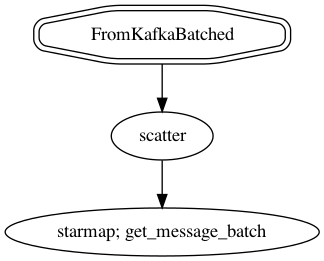

In [10]:
source.visualize()

In [11]:
outputs = []
h = source.map(json_loads).map(plus).buffer(5).gather().flatten().healing(interval = 5)
h.sink(outputs.append)

Output()

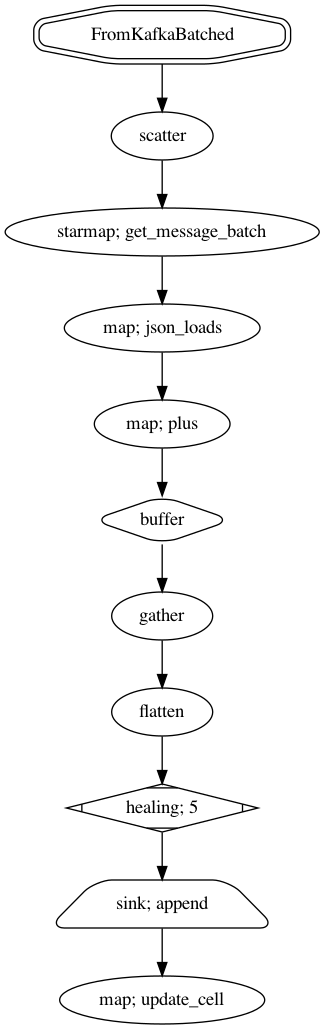

In [12]:
source.visualize()

In [13]:
source.start()

In [14]:
outputs

[]

In [15]:
from kafka import KafkaProducer
from kafka.partitioner import RoundRobinPartitioner

In [16]:
producer = KafkaProducer(
    bootstrap_servers = brokers.split(','),
    api_version = (0, 10),
    partitioner = RoundRobinPartitioner(),
)

INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: connecting to localhost:29092 [('::1', 29092, 0, 0) IPv6]
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: Connection complete.


In [17]:
producer.bootstrap_connected()

True

In [18]:
from datetime import datetime
import json

def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding = 'utf-8')
        value_bytes = bytes(value, encoding = 'utf-8')
        x = producer_instance.send(topic_name, value = value_bytes)
        return True
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))
        return False

INFO:root:healing successful: False, 2022-01-25 13:42:39.826759


## purposely raise the error

Based on function `plus`, if input bigger than 30, it will throw error.

In [19]:
import time

for count in range(35):
    data = {'no': count, 'datetime': str(datetime.now())}
    print(data)
    publish_message(
        producer, 'testing', 'streaming', json.dumps(data)
    )
    time.sleep(0.1)

INFO:kafka.conn:<BrokerConnection node_id=1 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: connecting to localhost:29092 [('::1', 29092, 0, 0) IPv6]
INFO:kafka.conn:<BrokerConnection node_id=1 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: Connection complete.
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connected> [IPv6 ('::1', 29092, 0, 0)]>: Closing connection. 


{'no': 0, 'datetime': '2022-01-25 13:42:40.017421'}
{'no': 1, 'datetime': '2022-01-25 13:42:40.121142'}
{'no': 2, 'datetime': '2022-01-25 13:42:40.224426'}
{'no': 3, 'datetime': '2022-01-25 13:42:40.325786'}
{'no': 4, 'datetime': '2022-01-25 13:42:40.429777'}
{'no': 5, 'datetime': '2022-01-25 13:42:40.533347'}
{'no': 6, 'datetime': '2022-01-25 13:42:40.637123'}
{'no': 7, 'datetime': '2022-01-25 13:42:40.740686'}
{'no': 8, 'datetime': '2022-01-25 13:42:40.846492'}
{'no': 9, 'datetime': '2022-01-25 13:42:40.951091'}
{'no': 10, 'datetime': '2022-01-25 13:42:41.057023'}
{'no': 11, 'datetime': '2022-01-25 13:42:41.159650'}
{'no': 12, 'datetime': '2022-01-25 13:42:41.265092'}
{'no': 13, 'datetime': '2022-01-25 13:42:41.369576'}
{'no': 14, 'datetime': '2022-01-25 13:42:41.474400'}
{'no': 15, 'datetime': '2022-01-25 13:42:41.578328'}


INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-18', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 0, 31, 32, set())"}
INFO:root:{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.tuple, key: tuple-ea463cf112d343e8abf6a8b9ac6d0aba>'}


{'no': 16, 'datetime': '2022-01-25 13:42:41.681175'}
{'no': 17, 'datetime': '2022-01-25 13:42:41.784469'}


INFO:root:{'function_name': 'starmap.get_message_batch', 'data': '<Future: pending, key: apply-8e4ea611-e840-40da-845b-b7535c66bdb1>'}
INFO:root:{'function_name': 'map.json_loads', 'data': '<Future: pending, key: json_loads--57d0ca21-bdb6-4c33-b340-122a17f7a960--10d5c416-8210-4c44-a8f5-0bbbd1528ab4>'}
INFO:root:{'function_name': 'map.plus', 'data': '<Future: pending, key: plus--57d0ca21-bdb6-4c33-b340-122a17f7a960--70fb718a-e733-4918-bae2-6a0791513b07>'}
INFO:root:{'function_name': 'buffer', 'data': '<Future: pending, key: plus--57d0ca21-bdb6-4c33-b340-122a17f7a960--70fb718a-e733-4918-bae2-6a0791513b07>'}
INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-18', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 1, 31, 32, set())"}
INFO:root:{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.tuple, key: tuple-fca04d5531904f28ab9dd756a37eedc2>'}
INFO:root:{'function_name': 'st

{'no': 18, 'datetime': '2022-01-25 13:42:41.885921'}
{'no': 19, 'datetime': '2022-01-25 13:42:41.991003'}


INFO:root:{'function_name': 'map.json_loads', 'data': '<Future: pending, key: json_loads--0c4400f2-0cc1-4bc0-9984-7f46162e5228--36f93ca3-4ba9-43ed-b37d-d6770c9c1638>'}
INFO:root:{'function_name': 'map.plus', 'data': '<Future: pending, key: plus--0c4400f2-0cc1-4bc0-9984-7f46162e5228--01b18a6d-d716-4450-bc1e-d9d58b1b5a5d>'}
INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-18', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 3, 31, 32, set())"}
INFO:root:{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.tuple, key: tuple-66c71325cae84ea0b8053ca7b5af54ec>'}
INFO:root:{'function_name': 'starmap.get_message_batch', 'data': '<Future: pending, key: apply-4df821d2-aeeb-45fb-985f-b48168c1033c>'}
INFO:root:{'function_name': 'map.json_loads', 'data': '<Future: pending, key: json_loads--dd523b22-9fa6-47de-a1b5-3ce8f6ed83fb--1159f21c-2805-421e-b5e1-e69b15834ee3>'}
INFO:root:{'funct

{'no': 20, 'datetime': '2022-01-25 13:42:42.093029'}
{'no': 21, 'datetime': '2022-01-25 13:42:42.193745'}
{'no': 22, 'datetime': '2022-01-25 13:42:42.299677'}
{'no': 23, 'datetime': '2022-01-25 13:42:42.402041'}


INFO:root:{'function_name': 'gather', 'data': "[({'partition': 0, 'offset': 31, 'topic': 'testing'}, 1), ({'partition': 0, 'offset': 32, 'topic': 'testing'}, 11)]"}
INFO:root:{'function_name': 'flatten', 'data': "({'partition': 0, 'offset': 31, 'topic': 'testing'}, 1)"}
INFO:root:{'function_name': 'flatten', 'data': "({'partition': 0, 'offset': 32, 'topic': 'testing'}, 11)"}
INFO:root:{'function_name': 'buffer', 'data': '<Future: pending, key: plus--2b95bb14-4006-4710-92a1-23c6b12d1894--4d2f4cf4-a459-416c-9528-b7885f21cdc1>'}
INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-18', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 7, 25, 25, set())"}
INFO:root:{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.tuple, key: tuple-43281a94491a4139a02d4f0ab5aa9681>'}
INFO:root:{'function_name': 'starmap.get_message_batch', 'data': '<Future: pending, key: apply-08032956-50c9-482

{'no': 24, 'datetime': '2022-01-25 13:42:42.507181'}
{'no': 25, 'datetime': '2022-01-25 13:42:42.609590'}


INFO:root:{'function_name': 'flatten', 'data': "({'partition': 4, 'offset': 32, 'topic': 'testing'}, 15)"}
INFO:root:{'function_name': 'buffer', 'data': '<Future: finished, type: builtins.list, key: plus--ed9f0150-7bf4-450e-abb1-a48222ae153a--f34634f2-a1e0-49ad-857a-79a912648615>'}
INFO:root:{'function_name': 'gather', 'data': "[({'partition': 5, 'offset': 25, 'topic': 'testing'}, 6), ({'partition': 5, 'offset': 26, 'topic': 'testing'}, 16)]"}
INFO:root:{'function_name': 'flatten', 'data': "({'partition': 5, 'offset': 25, 'topic': 'testing'}, 6)"}
INFO:root:{'function_name': 'flatten', 'data': "({'partition': 5, 'offset': 26, 'topic': 'testing'}, 16)"}
INFO:root:{'function_name': 'buffer', 'data': '<Future: finished, type: builtins.list, key: plus--37c4981b-e875-44bb-8c48-e8870e404dfb--72b6c2a0-9769-496c-89d3-9e4832fe407b>'}
INFO:root:{'function_name': 'gather', 'data': "[({'partition': 6, 'offset': 25, 'topic': 'testing'}, 7), ({'partition': 6, 'offset': 26, 'topic': 'testing'}, 17)]"

{'no': 26, 'datetime': '2022-01-25 13:42:42.712965'}
{'no': 27, 'datetime': '2022-01-25 13:42:42.818439'}
{'no': 28, 'datetime': '2022-01-25 13:42:42.920408'}
{'no': 29, 'datetime': '2022-01-25 13:42:43.024480'}
{'no': 30, 'datetime': '2022-01-25 13:42:43.127018'}
{'no': 31, 'datetime': '2022-01-25 13:42:43.230329'}
{'no': 32, 'datetime': '2022-01-25 13:42:43.333344'}
{'no': 33, 'datetime': '2022-01-25 13:42:43.434034'}
{'no': 34, 'datetime': '2022-01-25 13:42:43.537642'}


INFO:root:healing successful: True, 2022-01-25 13:42:44.922685
INFO:root:{'function_name': 'healing', 'data': "[{'topic': 'testing', 'partition': 0, 'offset': 31}, {'topic': 'testing', 'partition': 0, 'offset': 32}, {'topic': 'testing', 'partition': 1, 'offset': 31}, {'topic': 'testing', 'partition': 1, 'offset': 32}, {'topic': 'testing', 'partition': 2, 'offset': 31}, {'topic': 'testing', 'partition': 2, 'offset': 32}, {'topic': 'testing', 'partition': 3, 'offset': 31}, {'topic': 'testing', 'partition': 3, 'offset': 32}, {'topic': 'testing', 'partition': 4, 'offset': 31}, {'topic': 'testing', 'partition': 4, 'offset': 32}, {'topic': 'testing', 'partition': 5, 'offset': 25}, {'topic': 'testing', 'partition': 5, 'offset': 26}, {'topic': 'testing', 'partition': 6, 'offset': 25}, {'topic': 'testing', 'partition': 6, 'offset': 26}, {'topic': 'testing', 'partition': 7, 'offset': 25}, {'topic': 'testing', 'partition': 8, 'offset': 25}, {'topic': 'testing', 'partition': 9, 'offset': 25}]"}
IN

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x12f1b13b0>, <Future finished exception=Exception("({'partition': 1, 'offset': 34, 'topic': 'testing'}, {'no': 31, 'datetime': '2022-01-25 13:42:43.230329'}), 31 is bigger than 30")>)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/ioloop.py", line 779, in _discard_future_result
    future.result()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/Users/huseinzo

In [20]:
from waterhealer.healing import get_db

In [21]:
_, consumer, db = get_db(source)
consumer

In [23]:
offsets = consumer.committed(consumer.assignment())
lags = {}
for offset in offsets:
    _, high_offset = consumer.get_watermark_offsets(offset)
    lags[offset.partition] = high_offset - offset.offset
lags

{}

In [24]:
db.partitions

{'': <redis_collections.Dict at group-test-18- {}>,
 'testing<!>0': <redis_collections.Dict at group-test-18-testing<!>0 {}>,
 'testing<!>1': <redis_collections.Dict at group-test-18-testing<!>1 {33: 0, 34: 0}>,
 'testing<!>2': <redis_collections.Dict at group-test-18-testing<!>2 {33: 0, 34: 0}>,
 'testing<!>3': <redis_collections.Dict at group-test-18-testing<!>3 {33: 0, 34: 0}>,
 'testing<!>4': <redis_collections.Dict at group-test-18-testing<!>4 {33: 0, 34: 0}>,
 'testing<!>5': <redis_collections.Dict at group-test-18-testing<!>5 {27: 0}>,
 'testing<!>6': <redis_collections.Dict at group-test-18-testing<!>6 {27: 0}>,
 'testing<!>7': <redis_collections.Dict at group-test-18-testing<!>7 {26: 0, 27: 0}>,
 'testing<!>8': <redis_collections.Dict at group-test-18-testing<!>8 {}>,
 'testing<!>9': <redis_collections.Dict at group-test-18-testing<!>9 {}>}

INFO:root:healing successful: False, 2022-01-25 13:43:30.582653
INFO:root:healing successful: False, 2022-01-25 13:43:35.666302
INFO:root:healing successful: False, 2022-01-25 13:43:40.727284
INFO:root:healing successful: False, 2022-01-25 13:43:45.786554
INFO:root:healing successful: False, 2022-01-25 13:43:50.842166
INFO:root:healing successful: False, 2022-01-25 13:43:55.904420
INFO:root:healing successful: False, 2022-01-25 13:44:00.970579
INFO:root:healing successful: False, 2022-01-25 13:44:06.031166
INFO:root:healing successful: False, 2022-01-25 13:44:11.095078
